In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from PIL import Image
import torch
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import densenet121, densenet201
from monai.transforms import (
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor
)
from monai.utils import set_determinism

#from data_split import data_separator, get_oversampling
#from data_loader import load_and_preprocess_image, generate_path_dataset, augmenter
#from model_creation import start_model, set_check_poin_saver, set_check_point_saver_regression
#from model_evaluation import plot_model_history, get_dataset_prediction, evaluate_prediction

2024-04-26 14:56:51.999696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 14:56:52.195351: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 14:56:52.813912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/12559743/.local/lib/python3.10/site-packages/cv2/../../lib64::/opt/Qt/6.3.1/gcc_6/lib:/opt/Qt/6.3.1/gcc_6/lib
2024-04-26 14:56:52.814062: W tensorflow/stream_executor/platform/default/dso_loader.cc:

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [3]:
df = pd.read_csv('/home/12559743/DAVI/IC/Codes/df_cropped.csv')
#del df['Unnamed: 0']
#df = df.sample(frac = 1, random_state=2023).reset_index(drop=True)
df = df.dropna(axis=0)
print(len(df))
df.head()

1046


,Unnamed: 0,Patient,Sex,Date of birth,PAN Date,Age at PAN,PAN Path
0,0,SEBASTIAO ABAQUI,M,24/05/1943,25/10/2016,74.0,/home/12559743/DAVI/todos_pacientes/ABAQUI SEB...
1,1,ABEGAIR SOUZA SILVA,M,03/03/1981,28/09/2018,38.0,/home/12559743/DAVI/todos_pacientes/ABEGAIR SO...
2,2,ABEL GONCALVES DA CUNHA,M,01/03/1970,05/10/2016,47.0,/home/12559743/DAVI/todos_pacientes/ABEL GONÇA...
3,3,ABELARDO RODRIGUES DA SILVA,M,04/01/1977,13/11/2018,42.0,/home/12559743/DAVI/todos_pacientes/ABELARDO R...
4,4,JOSE BENEDITO DE ABREU,M,29/09/1938,13/04/2016,78.0,/home/12559743/DAVI/todos_pacientes/ABREU JOSE...


(array([  4.,  13.,  30.,  32., 126., 203., 170., 251., 189.,  28.]),
 array([ 0. ,  9.7, 19.4, 29.1, 38.8, 48.5, 58.2, 67.9, 77.6, 87.3, 97. ]),
 <BarContainer object of 10 artists>)

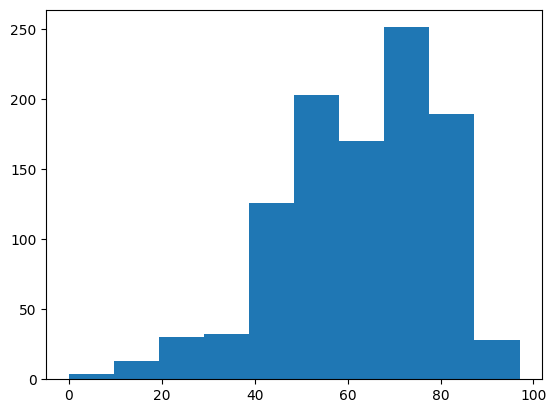

In [4]:
plt.hist(df['Age at PAN'])

In [5]:
print(df.iloc[5]['Patient'], df.iloc[5]['PAN Date'], df.iloc[5]['PAN Path'])

JOSE BENEDITO DE ABREU 16/01/2018 /home/12559743/DAVI/todos_pacientes/ABREU JOSE BENEDITO DE/JOSE BENEDITO DE ABREU- -- - - - 29-09-1938- PX from 16-01-2018 S0 I0(1)_cr.jpg


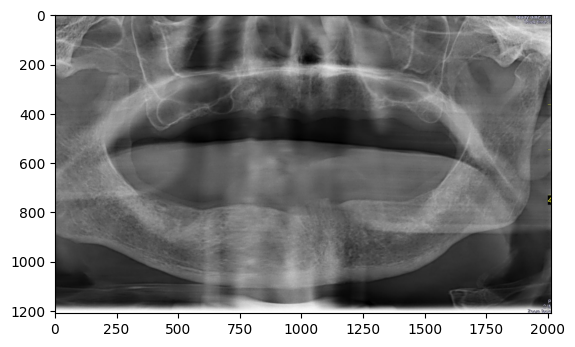

In [6]:
img = plt.imread(df.iloc[5]['PAN Path'])
plt.imshow(img)

In [7]:
from sklearn.model_selection import train_test_split as splitter
import random

def data_separator(data, train_rate=0.70, val_rate=0.50, SEED=42):
    
    '''
        Applies train, val, test split.
    '''
    
    # Separando train, val and test IMAGE path list
    
    if not val_rate:
        train, test = splitter(data, test_size= 1-train_rate, shuffle=True, random_state=SEED)
        
        return train, test
        
    elif val_rate:
        train, test = splitter(data, test_size= 1-train_rate, shuffle=True, random_state=SEED)
        
        val, test = splitter(test, test_size= 1-val_rate, shuffle=True, random_state=SEED)

        return train, val, test 



In [8]:
train, val, test = data_separator(df, train_rate=.8, val_rate=.5)
    
print(len(train), len(val), len(test))

836 105 105


In [9]:
train_list = (list(train['PAN Path']), list(train['Age at PAN']))
val_list = (list(val['PAN Path']), list(val['Age at PAN']))
test_list = (list(test['PAN Path']), list(test['Age at PAN']))

print(len(train), len(val), len(test))

836 105 105


In [10]:
image_list_train =[]
image_list_train_y = []

for i in range(len(train)):
    #print(i)
    x = cv2.imread(train_list[0][i])
    x = cv2.resize(x, (256, 256))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    image_list_train.append(x)
    image_list_train_y.append(train_list[1][i])
    
image_list_val = []
image_list_val_y = []

for i in range(len(val)):
    #print(i)
    x = cv2.imread(val_list[0][i])
    x = cv2.resize(x, (256, 256))
    X = cv2.cvtColor(x,  cv2.COLOR_BGR2RGB)
    image_list_val.append(x)
    image_list_val_y.append(val_list[1][i])
    
    
    
image_list_test = []
image_list_test_y = []

for i in range(len(test)):
    #print(i)
    x = cv2.imread(test_list[0][i])
    x = cv2.resize(x, (256, 256))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    image_list_test.append(x)
    image_list_test_y.append(test_list[1][i])

In [11]:
image_list_train_y = np.array(image_list_train_y)
image_list_val_y = np.array(image_list_val_y)
image_list_test_y = np.array(image_list_test_y)

In [12]:
w, h , c= image_list_train[0].shape

In [13]:
image_list_train = np.array(image_list_train)
image_list_val = np.array(image_list_val)
image_list_test = np.array(image_list_test)

In [14]:
image_list_train = image_list_train.reshape((-1, w,h,3))
image_list_val = image_list_val.reshape((-1, w,h,3))
image_list_test = image_list_test.reshape((-1, w,h,3))

In [15]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

image_list_train_tensor = torch.stack([transform(image) for image in image_list_train])
image_list_val_tensor = torch.stack([transform(image) for image in image_list_val])
image_list_test_tensor = torch.stack([transform(image) for image in image_list_test])

In [16]:
image_list_train_tensor.shape

torch.Size([836, 3, 256, 256])

In [17]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, labels = None, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx] if self.labels is not None else None
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
def transform_image(image):
    image = torch.tensor(image, dtype=torch.float32)
    
    image = image / 255.0
    return image

dataset = CustomDataset(image_list_train, image_list_train_y, transform = transform_image)

In [18]:
batch_size = 16

train_ds = CustomDataset(image_list_train_tensor, image_list_train_y, transform_image)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

val_ds = CustomDataset(image_list_val_tensor, image_list_val_y, transform_image)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=4)

test_ds = CustomDataset(image_list_test_tensor, image_list_test_y, transform_image)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [19]:
import torch.nn as nn
class MyModel(nn.Module):
    def __init__(self, drop_prob = 0.2):
        super(MyModel, self).__init__()
        #self.flatten = nn.Flatten()
        self.regression_model = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=(5,5), padding=2),
            nn.ReLU(),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(128, 64, kernel_size=(1,1)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4194304, 64),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(64,1),
        )
    def forward(self, x):
        #x = self.flatten(x)
        regression = self.regression_model(x)
        return regression


In [20]:
model = MyModel().to(device)
model

MyModel(
  (regression_model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=4194304, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [22]:
class Complexity:
    def __init__(self):
        self.bins = 100

    def entropy(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        prob = histogram
        log_prob = histogram.log()
        plogp = prob*log_prob
        plogp[torch.isnan(plogp)] = 0
        return plogp.sum().detach().cpu().numpy()

    def desiquilibrium(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        histogram = histogram - self.normal_prob()
        return histogram.square().sum().cpu().numpy()

    def complexity(self, p):
        return self.entropy(p) * self.desiquilibrium(p)


    def normal_prob(self):
        return 1.0/self.bins

def extract_model_data(model, model_data=None):
    if model_data is None:
        model_data = dict()
    c = Complexity()
    for name, param in model.named_parameters():
        if param.requires_grad:
            # we got a valid parameter to extract
            if name not in model_data.keys():
                model_data[name] = {'entropy' : list(), 'desiquilibrium' : list(), 'complexity' : list() }
            model_data[name]['entropy'].append(c.entropy(param.data))
            model_data[name]['desiquilibrium'].append(c.desiquilibrium(param.data))
            model_data[name]['complexity'].append(c.complexity(param.data))
    return model_data

In [23]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),1e-4)

In [24]:
import tempfile
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp7ww9e6a5


In [24]:
def r_squered(y_false, y_true):
    sse=torch.sum((y_true-y_false)**2)
    sst = torch.sum((y_true-torch.mean(y_true))**2)
    r2 = 1 - sse/sst
    return r2.item()

In [25]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

max_epochs = 50
val_interval = 1


model.to(device)


model_data = None
single_complexity = list()
single_entropy = list()
single_disequilibrium = list()
single_loss = list()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze(dim=1)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

        # EXTRACT MODEL DATA
        model_data = extract_model_data(model, model_data)
        myp = torch.nn.utils.parameters_to_vector(model.parameters())
        single_complexity.append(Complexity().complexity(myp))
        single_entropy.append(Complexity().entropy(myp))
        single_disequilibrium.append(Complexity().desiquilibrium(myp))
        single_loss.append(loss.item())

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            auc_metric = compute_roc_auc(
                y_pred, y)
            metric_values.append(auc_metric)
            '''
            y_one_hot = label_binarize(y.cpu().numpy(), classes=np.arange(num_classes))
            fpr, tpr, _ = roc_curve(y_one_hot.ravel(), y_pred.cpu().numpy().ravel())
            auc_value = auc(fpr, tpr)
            '''
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 3792.8591
2/52, train_loss: 2720.3975
3/52, train_loss: 2301.4858
4/52, train_loss: 1171.0809
5/52, train_loss: 504.7292
6/52, train_loss: 388.7499
7/52, train_loss: 573.9359
8/52, train_loss: 377.4233
9/52, train_loss: 650.2620
10/52, train_loss: 1038.1991
11/52, train_loss: 893.8752
12/52, train_loss: 642.9485
13/52, train_loss: 944.1666
14/52, train_loss: 596.0585
15/52, train_loss: 605.2391
16/52, train_loss: 325.9622
17/52, train_loss: 416.5635
18/52, train_loss: 402.2503
19/52, train_loss: 245.3850
20/52, train_loss: 428.3777
21/52, train_loss: 347.7526
22/52, train_loss: 675.4266
23/52, train_loss: 743.2417
24/52, train_loss: 299.5618
25/52, train_loss: 574.8152
26/52, train_loss: 566.8976
27/52, train_loss: 515.5490
28/52, train_loss: 419.7110
29/52, train_loss: 543.7082
30/52, train_loss: 393.1402
31/52, train_loss: 628.1582
32/52, train_loss: 244.6119
33/52, train_loss: 166.1577
34/52, train_loss: 331.3273
35/52, train_loss: 302.3102
36/52, train_loss: 371.5

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 1 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 2/50


y values must be 0 or 1, but in [17.0, 23.0, 27.0, 31.0, 33.0, 38.0, 41.0, 42.0, 44.0, 45.0, 46.0, 47.0, 48.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 60.0, 61.0, 62.0, 64.0, 65.0, 66.0, 67.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 85.0], skip AUC computation and return `Nan`.
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().de

1/52, train_loss: 187.8905
2/52, train_loss: 319.2726
3/52, train_loss: 409.4683
4/52, train_loss: 349.1240
5/52, train_loss: 299.9685
6/52, train_loss: 266.1953
7/52, train_loss: 414.5837
8/52, train_loss: 325.3044
9/52, train_loss: 544.9473
10/52, train_loss: 133.0287
11/52, train_loss: 278.9223
12/52, train_loss: 427.9446
13/52, train_loss: 325.3146
14/52, train_loss: 416.6138
15/52, train_loss: 349.6368
16/52, train_loss: 265.1139
17/52, train_loss: 367.3723
18/52, train_loss: 343.5555
19/52, train_loss: 323.0194
20/52, train_loss: 318.1846
21/52, train_loss: 314.6224
22/52, train_loss: 638.1523
23/52, train_loss: 531.9637
24/52, train_loss: 218.5487
25/52, train_loss: 327.3043
26/52, train_loss: 429.8949
27/52, train_loss: 196.1772
28/52, train_loss: 170.1078
29/52, train_loss: 323.0292
30/52, train_loss: 233.7444
31/52, train_loss: 444.4487
32/52, train_loss: 186.3295
33/52, train_loss: 238.9911
34/52, train_loss: 694.9690
35/52, train_loss: 299.3550
36/52, train_loss: 287.0341
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 2 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 3/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 592.2396
2/52, train_loss: 383.6947
3/52, train_loss: 256.5019
4/52, train_loss: 404.1532
5/52, train_loss: 319.9418
6/52, train_loss: 390.7811
7/52, train_loss: 477.4110
8/52, train_loss: 274.8494
9/52, train_loss: 342.6742
10/52, train_loss: 286.4607
11/52, train_loss: 456.7115
12/52, train_loss: 373.9187
13/52, train_loss: 428.7953
14/52, train_loss: 334.6597
15/52, train_loss: 260.6189
16/52, train_loss: 346.2408
17/52, train_loss: 478.0334
18/52, train_loss: 140.9166
19/52, train_loss: 427.5559
20/52, train_loss: 223.9619
21/52, train_loss: 204.6013
22/52, train_loss: 240.9991
23/52, train_loss: 193.4801
24/52, train_loss: 345.0497
25/52, train_loss: 196.5583
26/52, train_loss: 456.5921
27/52, train_loss: 434.7312
28/52, train_loss: 453.2982
29/52, train_loss: 328.2806
30/52, train_loss: 375.3948
31/52, train_loss: 452.5915
32/52, train_loss: 357.2503
33/52, train_loss: 344.0018
34/52, train_loss: 304.7275
35/52, train_loss: 455.4784
36/52, train_loss: 329.5770
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 3 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 4/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 412.2371
2/52, train_loss: 365.9682
3/52, train_loss: 429.2307
4/52, train_loss: 340.5768
5/52, train_loss: 295.1026
6/52, train_loss: 596.5894
7/52, train_loss: 319.7686
8/52, train_loss: 233.3741
9/52, train_loss: 520.5782
10/52, train_loss: 297.9565
11/52, train_loss: 350.0825
12/52, train_loss: 308.1449
13/52, train_loss: 387.3198
14/52, train_loss: 267.5136
15/52, train_loss: 365.9434
16/52, train_loss: 384.2778
17/52, train_loss: 725.5751
18/52, train_loss: 193.0701
19/52, train_loss: 317.3580
20/52, train_loss: 468.0183
21/52, train_loss: 206.3508
22/52, train_loss: 615.3975
23/52, train_loss: 294.7351
24/52, train_loss: 297.0235
25/52, train_loss: 286.6325
26/52, train_loss: 279.6363
27/52, train_loss: 299.3830
28/52, train_loss: 264.0534
29/52, train_loss: 255.8200
30/52, train_loss: 519.7441
31/52, train_loss: 248.5587
32/52, train_loss: 595.5775
33/52, train_loss: 383.1155
34/52, train_loss: 463.3457
35/52, train_loss: 426.7927
36/52, train_loss: 355.9127
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 4 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 5/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 473.4160
2/52, train_loss: 626.2136
3/52, train_loss: 246.4185
4/52, train_loss: 334.2776
5/52, train_loss: 571.3278
6/52, train_loss: 518.9631
7/52, train_loss: 251.2272
8/52, train_loss: 434.5480
9/52, train_loss: 242.3951
10/52, train_loss: 127.2217
11/52, train_loss: 205.4895
12/52, train_loss: 187.7449
13/52, train_loss: 150.8912
14/52, train_loss: 295.4992
15/52, train_loss: 792.5074
16/52, train_loss: 440.2349
17/52, train_loss: 243.3242
18/52, train_loss: 371.9327
19/52, train_loss: 315.7905
20/52, train_loss: 475.5671
21/52, train_loss: 265.6519
22/52, train_loss: 800.7891
23/52, train_loss: 205.8788
24/52, train_loss: 642.7550
25/52, train_loss: 625.5554
26/52, train_loss: 405.7009
27/52, train_loss: 330.8889
28/52, train_loss: 204.5061
29/52, train_loss: 481.7802
30/52, train_loss: 357.5372
31/52, train_loss: 155.2728
32/52, train_loss: 635.2569
33/52, train_loss: 190.2149
34/52, train_loss: 492.8078
35/52, train_loss: 280.8686
36/52, train_loss: 217.6159
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 5 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 6/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 330.4302
2/52, train_loss: 487.3422
3/52, train_loss: 604.7142
4/52, train_loss: 242.1557
5/52, train_loss: 549.3788
6/52, train_loss: 548.1860
7/52, train_loss: 156.9134
8/52, train_loss: 416.8176
9/52, train_loss: 346.3089
10/52, train_loss: 192.6821
11/52, train_loss: 296.9046
12/52, train_loss: 417.9306
13/52, train_loss: 307.3573
14/52, train_loss: 221.7763
15/52, train_loss: 324.1674
16/52, train_loss: 210.6237
17/52, train_loss: 326.1058
18/52, train_loss: 267.7798
19/52, train_loss: 393.3219
20/52, train_loss: 369.5027
21/52, train_loss: 675.9800
22/52, train_loss: 178.5950
23/52, train_loss: 337.3013
24/52, train_loss: 569.7638
25/52, train_loss: 242.7048
26/52, train_loss: 433.5944
27/52, train_loss: 782.7035
28/52, train_loss: 325.6578
29/52, train_loss: 276.5650
30/52, train_loss: 247.7475
31/52, train_loss: 534.3287
32/52, train_loss: 269.8859
33/52, train_loss: 440.8551
34/52, train_loss: 538.7084
35/52, train_loss: 549.4656
36/52, train_loss: 472.9056
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 6 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 7/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 257.8513
2/52, train_loss: 238.5620
3/52, train_loss: 493.3620
4/52, train_loss: 322.4239
5/52, train_loss: 726.0006
6/52, train_loss: 435.2726
7/52, train_loss: 433.6927
8/52, train_loss: 325.7677
9/52, train_loss: 314.3879
10/52, train_loss: 333.0117
11/52, train_loss: 176.9294
12/52, train_loss: 258.5839
13/52, train_loss: 286.8648
14/52, train_loss: 219.7018
15/52, train_loss: 87.1295
16/52, train_loss: 310.0591
17/52, train_loss: 249.8178
18/52, train_loss: 247.4459
19/52, train_loss: 158.6879
20/52, train_loss: 617.6505
21/52, train_loss: 148.2749
22/52, train_loss: 166.3734
23/52, train_loss: 480.5096
24/52, train_loss: 136.0493
25/52, train_loss: 419.6448
26/52, train_loss: 609.7645
27/52, train_loss: 373.3702
28/52, train_loss: 277.5789
29/52, train_loss: 438.1201
30/52, train_loss: 305.8111
31/52, train_loss: 226.4224
32/52, train_loss: 463.5230
33/52, train_loss: 433.3694
34/52, train_loss: 719.6902
35/52, train_loss: 295.4962
36/52, train_loss: 414.1282
37

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 7 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 8/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 174.1937
2/52, train_loss: 418.9368
3/52, train_loss: 415.6022
4/52, train_loss: 264.3128
5/52, train_loss: 372.4006
6/52, train_loss: 154.5173
7/52, train_loss: 209.0854
8/52, train_loss: 315.1967
9/52, train_loss: 220.3140
10/52, train_loss: 264.0779
11/52, train_loss: 202.0517
12/52, train_loss: 200.2080
13/52, train_loss: 336.8312
14/52, train_loss: 462.6172
15/52, train_loss: 387.0867
16/52, train_loss: 482.9471
17/52, train_loss: 279.9756
18/52, train_loss: 355.9135
19/52, train_loss: 345.0658
20/52, train_loss: 354.9293
21/52, train_loss: 440.4082
22/52, train_loss: 388.6151
23/52, train_loss: 280.4570
24/52, train_loss: 298.5977
25/52, train_loss: 353.6591
26/52, train_loss: 280.9128
27/52, train_loss: 402.9485
28/52, train_loss: 285.9936
29/52, train_loss: 270.3578
30/52, train_loss: 135.0978
31/52, train_loss: 372.0214
32/52, train_loss: 419.5836
33/52, train_loss: 336.4073
34/52, train_loss: 666.4244
35/52, train_loss: 418.9608
36/52, train_loss: 429.9349
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 8 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 9/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 171.6294
2/52, train_loss: 478.0602
3/52, train_loss: 266.7588
4/52, train_loss: 357.4656
5/52, train_loss: 353.4094
6/52, train_loss: 247.0190
7/52, train_loss: 271.0828
8/52, train_loss: 702.2581
9/52, train_loss: 347.5146
10/52, train_loss: 321.6952
11/52, train_loss: 347.3707
12/52, train_loss: 496.0096
13/52, train_loss: 376.7933
14/52, train_loss: 290.4250
15/52, train_loss: 551.3077
16/52, train_loss: 576.4384
17/52, train_loss: 412.1620
18/52, train_loss: 324.3961
19/52, train_loss: 548.7531
20/52, train_loss: 248.0691
21/52, train_loss: 453.3062
22/52, train_loss: 210.2699
23/52, train_loss: 208.1707
24/52, train_loss: 426.7200
25/52, train_loss: 730.2075
26/52, train_loss: 437.5322
27/52, train_loss: 432.4479
28/52, train_loss: 170.5670
29/52, train_loss: 306.4772
30/52, train_loss: 230.8502
31/52, train_loss: 254.6798
32/52, train_loss: 462.7753
33/52, train_loss: 245.8570
34/52, train_loss: 444.2867
35/52, train_loss: 388.3136
36/52, train_loss: 366.7531
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 9 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 10/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 252.2527
2/52, train_loss: 262.0114
3/52, train_loss: 334.2265
4/52, train_loss: 488.8641
5/52, train_loss: 441.9210
6/52, train_loss: 317.1083
7/52, train_loss: 134.6060
8/52, train_loss: 384.7207
9/52, train_loss: 450.1762
10/52, train_loss: 317.1697
11/52, train_loss: 303.9932
12/52, train_loss: 257.9800
13/52, train_loss: 313.7009
14/52, train_loss: 249.4993
15/52, train_loss: 313.2089
16/52, train_loss: 328.0019
17/52, train_loss: 435.3273
18/52, train_loss: 401.6586
19/52, train_loss: 139.8796
20/52, train_loss: 275.1842
21/52, train_loss: 530.3400
22/52, train_loss: 519.0654
23/52, train_loss: 193.1557
24/52, train_loss: 289.9439
25/52, train_loss: 240.1217
26/52, train_loss: 375.1878
27/52, train_loss: 315.1826
28/52, train_loss: 587.9995
29/52, train_loss: 245.6441
30/52, train_loss: 149.1415
31/52, train_loss: 470.0517
32/52, train_loss: 321.5292
33/52, train_loss: 450.8706
34/52, train_loss: 272.0696
35/52, train_loss: 226.1151
36/52, train_loss: 329.4642
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 10 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 11/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 334.6967
2/52, train_loss: 305.7681
3/52, train_loss: 346.0100
4/52, train_loss: 248.0249
5/52, train_loss: 223.6031
6/52, train_loss: 403.8553
7/52, train_loss: 294.8738
8/52, train_loss: 249.9930
9/52, train_loss: 394.0463
10/52, train_loss: 222.5577
11/52, train_loss: 384.7154
12/52, train_loss: 315.1274
13/52, train_loss: 261.3380
14/52, train_loss: 196.3054
15/52, train_loss: 276.1001
16/52, train_loss: 95.7433
17/52, train_loss: 170.2648
18/52, train_loss: 565.4481
19/52, train_loss: 682.9384
20/52, train_loss: 290.6981
21/52, train_loss: 286.1976
22/52, train_loss: 514.8106
23/52, train_loss: 138.9902
24/52, train_loss: 341.9320
25/52, train_loss: 359.0705
26/52, train_loss: 235.0056
27/52, train_loss: 346.1275
28/52, train_loss: 677.2510
29/52, train_loss: 346.8517
30/52, train_loss: 515.8892
31/52, train_loss: 300.0634
32/52, train_loss: 306.6910
33/52, train_loss: 177.0688
34/52, train_loss: 308.7135
35/52, train_loss: 262.3171
36/52, train_loss: 448.5306
37

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 11 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 12/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 252.4692
2/52, train_loss: 441.3962
3/52, train_loss: 482.5377
4/52, train_loss: 414.7921
5/52, train_loss: 370.0459
6/52, train_loss: 225.5070
7/52, train_loss: 435.2029
8/52, train_loss: 171.9705
9/52, train_loss: 233.0452
10/52, train_loss: 510.4855
11/52, train_loss: 424.0166
12/52, train_loss: 343.1777
13/52, train_loss: 206.0976
14/52, train_loss: 392.9653
15/52, train_loss: 291.8941
16/52, train_loss: 307.1218
17/52, train_loss: 385.1276
18/52, train_loss: 333.0151
19/52, train_loss: 351.3828
20/52, train_loss: 684.2360
21/52, train_loss: 151.3668
22/52, train_loss: 399.2112
23/52, train_loss: 453.5738
24/52, train_loss: 235.1652
25/52, train_loss: 178.0584
26/52, train_loss: 363.1564
27/52, train_loss: 480.4547
28/52, train_loss: 549.7106
29/52, train_loss: 427.8386
30/52, train_loss: 165.3006
31/52, train_loss: 263.0569
32/52, train_loss: 432.3591
33/52, train_loss: 410.9237
34/52, train_loss: 240.0135
35/52, train_loss: 289.6894
36/52, train_loss: 434.2653
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 12 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 13/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 287.9967
2/52, train_loss: 385.8059
3/52, train_loss: 280.7344
4/52, train_loss: 407.7919
5/52, train_loss: 404.8824
6/52, train_loss: 255.6826
7/52, train_loss: 129.2562
8/52, train_loss: 214.3833
9/52, train_loss: 342.8932
10/52, train_loss: 406.4855
11/52, train_loss: 279.4156
12/52, train_loss: 428.3833
13/52, train_loss: 310.4963
14/52, train_loss: 445.5900
15/52, train_loss: 450.7827
16/52, train_loss: 502.4510
17/52, train_loss: 424.9383
18/52, train_loss: 427.7947
19/52, train_loss: 265.1621
20/52, train_loss: 157.5130
21/52, train_loss: 502.5199
22/52, train_loss: 317.9388
23/52, train_loss: 454.6705
24/52, train_loss: 606.2799
25/52, train_loss: 116.8126
26/52, train_loss: 331.6664
27/52, train_loss: 717.5558
28/52, train_loss: 284.5968
29/52, train_loss: 350.6493
30/52, train_loss: 308.2976
31/52, train_loss: 396.3385
32/52, train_loss: 261.6697
33/52, train_loss: 506.8275
34/52, train_loss: 427.7437
35/52, train_loss: 298.9473
36/52, train_loss: 442.3031
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 13 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 14/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 356.3392
2/52, train_loss: 301.3398
3/52, train_loss: 295.4554
4/52, train_loss: 295.3550
5/52, train_loss: 315.8926
6/52, train_loss: 464.5042
7/52, train_loss: 222.1092
8/52, train_loss: 317.9755
9/52, train_loss: 152.0378
10/52, train_loss: 173.2890
11/52, train_loss: 340.2365
12/52, train_loss: 279.0594
13/52, train_loss: 163.8676
14/52, train_loss: 174.4143
15/52, train_loss: 229.5436
16/52, train_loss: 145.0286
17/52, train_loss: 216.8706
18/52, train_loss: 334.1775
19/52, train_loss: 253.1461
20/52, train_loss: 460.0724
21/52, train_loss: 299.4153
22/52, train_loss: 141.6762
23/52, train_loss: 614.5195
24/52, train_loss: 438.1096
25/52, train_loss: 346.7583
26/52, train_loss: 477.3719
27/52, train_loss: 317.3286
28/52, train_loss: 279.5167
29/52, train_loss: 278.3317
30/52, train_loss: 296.1947
31/52, train_loss: 667.0137
32/52, train_loss: 333.1720
33/52, train_loss: 243.8902
34/52, train_loss: 437.8765
35/52, train_loss: 320.5960
36/52, train_loss: 252.4212
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 14 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 15/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 256.2867
2/52, train_loss: 446.5133
3/52, train_loss: 516.1042
4/52, train_loss: 243.4371
5/52, train_loss: 469.6596
6/52, train_loss: 473.5536
7/52, train_loss: 437.2186
8/52, train_loss: 174.6757
9/52, train_loss: 324.1566
10/52, train_loss: 479.1241
11/52, train_loss: 376.5717
12/52, train_loss: 276.2072
13/52, train_loss: 660.9364
14/52, train_loss: 371.0366
15/52, train_loss: 267.5669
16/52, train_loss: 530.1553
17/52, train_loss: 226.0211
18/52, train_loss: 327.3726
19/52, train_loss: 276.2775
20/52, train_loss: 481.3444
21/52, train_loss: 375.6037
22/52, train_loss: 258.3446
23/52, train_loss: 374.8170
24/52, train_loss: 193.1484
25/52, train_loss: 399.5116
26/52, train_loss: 241.1995
27/52, train_loss: 262.5695
28/52, train_loss: 297.4925
29/52, train_loss: 376.7531
30/52, train_loss: 366.1496
31/52, train_loss: 239.2254
32/52, train_loss: 387.2307
33/52, train_loss: 281.7121
34/52, train_loss: 255.1203
35/52, train_loss: 451.2914
36/52, train_loss: 303.7927
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 15 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 16/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 300.4407
2/52, train_loss: 194.1698
3/52, train_loss: 206.0788
4/52, train_loss: 339.3461
5/52, train_loss: 602.2899
6/52, train_loss: 504.1423
7/52, train_loss: 551.9883
8/52, train_loss: 191.8841
9/52, train_loss: 243.0697
10/52, train_loss: 471.8211
11/52, train_loss: 92.6379
12/52, train_loss: 254.9327
13/52, train_loss: 549.8257
14/52, train_loss: 276.7224
15/52, train_loss: 378.4882
16/52, train_loss: 526.7197
17/52, train_loss: 192.3749
18/52, train_loss: 271.2942
19/52, train_loss: 339.1284
20/52, train_loss: 521.2898
21/52, train_loss: 320.2783
22/52, train_loss: 366.6985
23/52, train_loss: 303.7313
24/52, train_loss: 300.6573
25/52, train_loss: 287.3392
26/52, train_loss: 365.2462
27/52, train_loss: 419.6238
28/52, train_loss: 311.0951
29/52, train_loss: 240.0909
30/52, train_loss: 301.5624
31/52, train_loss: 333.4247
32/52, train_loss: 361.0175
33/52, train_loss: 592.5941
34/52, train_loss: 171.9369
35/52, train_loss: 285.4915
36/52, train_loss: 291.7651
37

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 16 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 17/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 224.2135
2/52, train_loss: 287.8737
3/52, train_loss: 726.2134
4/52, train_loss: 368.3209
5/52, train_loss: 254.9714
6/52, train_loss: 267.2691
7/52, train_loss: 233.5046
8/52, train_loss: 276.2604
9/52, train_loss: 229.5535
10/52, train_loss: 502.0120
11/52, train_loss: 482.0403
12/52, train_loss: 267.0826
13/52, train_loss: 251.7896
14/52, train_loss: 303.6840
15/52, train_loss: 254.7276
16/52, train_loss: 554.0957
17/52, train_loss: 136.4396
18/52, train_loss: 599.8417
19/52, train_loss: 287.7502
20/52, train_loss: 312.8383
21/52, train_loss: 227.4176
22/52, train_loss: 444.7047
23/52, train_loss: 373.5861
24/52, train_loss: 266.3891
25/52, train_loss: 280.5467
26/52, train_loss: 212.3458
27/52, train_loss: 373.7827
28/52, train_loss: 209.6149
29/52, train_loss: 323.1592
30/52, train_loss: 197.4622
31/52, train_loss: 313.9123
32/52, train_loss: 148.7722
33/52, train_loss: 264.3578
34/52, train_loss: 312.7292
35/52, train_loss: 364.6072
36/52, train_loss: 270.4860
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 17 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 18/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 578.7745
2/52, train_loss: 222.7101
3/52, train_loss: 329.8394
4/52, train_loss: 507.8727
5/52, train_loss: 299.2392
6/52, train_loss: 565.2529
7/52, train_loss: 945.3205
8/52, train_loss: 266.5802
9/52, train_loss: 251.8716
10/52, train_loss: 284.9920
11/52, train_loss: 377.4393
12/52, train_loss: 347.1664
13/52, train_loss: 340.6511
14/52, train_loss: 491.1306
15/52, train_loss: 334.0027
16/52, train_loss: 151.3903
17/52, train_loss: 230.0688
18/52, train_loss: 565.9962
19/52, train_loss: 400.4872
20/52, train_loss: 442.8550
21/52, train_loss: 235.4681
22/52, train_loss: 286.2440
23/52, train_loss: 320.6577
24/52, train_loss: 219.2482
25/52, train_loss: 228.2801
26/52, train_loss: 217.0271
27/52, train_loss: 272.6692
28/52, train_loss: 209.8742
29/52, train_loss: 203.7412
30/52, train_loss: 590.8489
31/52, train_loss: 184.9898
32/52, train_loss: 285.9123
33/52, train_loss: 292.2992
34/52, train_loss: 360.5580
35/52, train_loss: 443.7527
36/52, train_loss: 510.3253
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 18 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 19/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 508.1548
2/52, train_loss: 176.3670
3/52, train_loss: 359.5212
4/52, train_loss: 198.8039
5/52, train_loss: 135.7251
6/52, train_loss: 314.2515
7/52, train_loss: 212.5900
8/52, train_loss: 714.9596
9/52, train_loss: 334.8807
10/52, train_loss: 619.1282
11/52, train_loss: 252.4607
12/52, train_loss: 345.5993
13/52, train_loss: 408.5663
14/52, train_loss: 408.7218
15/52, train_loss: 437.3645
16/52, train_loss: 315.8218
17/52, train_loss: 612.5155
18/52, train_loss: 576.2946
19/52, train_loss: 303.9308
20/52, train_loss: 491.0399
21/52, train_loss: 511.5033
22/52, train_loss: 801.8401
23/52, train_loss: 227.9525
24/52, train_loss: 278.9866
25/52, train_loss: 384.8999
26/52, train_loss: 312.2241
27/52, train_loss: 225.1421
28/52, train_loss: 237.5484
29/52, train_loss: 311.1494
30/52, train_loss: 190.4918
31/52, train_loss: 191.1269
32/52, train_loss: 397.2157
33/52, train_loss: 246.2978
34/52, train_loss: 329.0122
35/52, train_loss: 556.2048
36/52, train_loss: 326.3783
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 19 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 20/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 341.4078
2/52, train_loss: 516.4762
3/52, train_loss: 620.5452
4/52, train_loss: 268.5911
5/52, train_loss: 306.1458
6/52, train_loss: 599.7731
7/52, train_loss: 524.0989
8/52, train_loss: 227.4604
9/52, train_loss: 249.8299
10/52, train_loss: 231.3269
11/52, train_loss: 283.4855
12/52, train_loss: 387.9360
13/52, train_loss: 156.5289
14/52, train_loss: 446.9081
15/52, train_loss: 192.2056
16/52, train_loss: 551.7971
17/52, train_loss: 153.7237
18/52, train_loss: 230.9771
19/52, train_loss: 531.4403
20/52, train_loss: 225.2313
21/52, train_loss: 288.6353
22/52, train_loss: 431.0894
23/52, train_loss: 295.1938
24/52, train_loss: 307.5307
25/52, train_loss: 847.8290
26/52, train_loss: 490.5288
27/52, train_loss: 407.0401
28/52, train_loss: 360.3937
29/52, train_loss: 338.1407
30/52, train_loss: 215.8024
31/52, train_loss: 244.0921
32/52, train_loss: 504.9304
33/52, train_loss: 474.9355
34/52, train_loss: 204.0428
35/52, train_loss: 254.5424
36/52, train_loss: 244.5218
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 20 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 21/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 182.6019
2/52, train_loss: 253.0070
3/52, train_loss: 373.6141
4/52, train_loss: 504.2932
5/52, train_loss: 260.5696
6/52, train_loss: 684.2668
7/52, train_loss: 332.8551
8/52, train_loss: 176.5914
9/52, train_loss: 407.6469
10/52, train_loss: 412.9762
11/52, train_loss: 418.2051
12/52, train_loss: 477.6484
13/52, train_loss: 211.0722
14/52, train_loss: 365.9459
15/52, train_loss: 386.6202
16/52, train_loss: 556.1414
17/52, train_loss: 331.1605
18/52, train_loss: 234.3797
19/52, train_loss: 222.4679
20/52, train_loss: 233.7374
21/52, train_loss: 384.6956
22/52, train_loss: 230.3590
23/52, train_loss: 362.8218
24/52, train_loss: 192.4157
25/52, train_loss: 313.7587
26/52, train_loss: 330.5142
27/52, train_loss: 187.0903
28/52, train_loss: 221.1433
29/52, train_loss: 241.8252
30/52, train_loss: 250.3524
31/52, train_loss: 558.2593
32/52, train_loss: 344.0653
33/52, train_loss: 345.7911
34/52, train_loss: 473.1264
35/52, train_loss: 388.5497
36/52, train_loss: 289.8040
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 21 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 22/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 135.7990
2/52, train_loss: 238.7469
3/52, train_loss: 440.5985
4/52, train_loss: 309.1217
5/52, train_loss: 385.7779
6/52, train_loss: 274.4984
7/52, train_loss: 409.8224
8/52, train_loss: 423.8602
9/52, train_loss: 310.5057
10/52, train_loss: 240.3484
11/52, train_loss: 304.7295
12/52, train_loss: 103.9984
13/52, train_loss: 607.5383
14/52, train_loss: 531.7696
15/52, train_loss: 203.0574
16/52, train_loss: 359.3765
17/52, train_loss: 156.2115
18/52, train_loss: 231.7661
19/52, train_loss: 317.8975
20/52, train_loss: 539.0664
21/52, train_loss: 350.9874
22/52, train_loss: 351.7924
23/52, train_loss: 425.4911
24/52, train_loss: 314.4074
25/52, train_loss: 197.6456
26/52, train_loss: 133.3475
27/52, train_loss: 322.8157
28/52, train_loss: 359.6340
29/52, train_loss: 150.9674
30/52, train_loss: 362.5864
31/52, train_loss: 433.7855
32/52, train_loss: 461.3105
33/52, train_loss: 465.8262
34/52, train_loss: 279.9489
35/52, train_loss: 377.2476
36/52, train_loss: 143.4267
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 22 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 23/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 260.8168
2/52, train_loss: 290.5670
3/52, train_loss: 263.7692
4/52, train_loss: 444.4279
5/52, train_loss: 365.0339
6/52, train_loss: 264.4053
7/52, train_loss: 402.5685
8/52, train_loss: 207.3453
9/52, train_loss: 309.8636
10/52, train_loss: 449.0388
11/52, train_loss: 143.7135
12/52, train_loss: 228.6173
13/52, train_loss: 138.2992
14/52, train_loss: 319.7075
15/52, train_loss: 353.7952
16/52, train_loss: 299.0490
17/52, train_loss: 243.0017
18/52, train_loss: 486.2740
19/52, train_loss: 699.5886
20/52, train_loss: 286.0150
21/52, train_loss: 347.4666
22/52, train_loss: 229.6029
23/52, train_loss: 394.6687
24/52, train_loss: 358.7944
25/52, train_loss: 395.8748
26/52, train_loss: 229.3065
27/52, train_loss: 444.8408
28/52, train_loss: 423.4291
29/52, train_loss: 301.4141
30/52, train_loss: 455.7883
31/52, train_loss: 199.7447
32/52, train_loss: 490.9192
33/52, train_loss: 192.7018
34/52, train_loss: 281.2283
35/52, train_loss: 385.8108
36/52, train_loss: 189.4546
3

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 23 current AUC: nan current accuracy: 0.0000 best AUC: -1.0000 at epoch: -1
----------
epoch 24/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/52, train_loss: 343.8013
2/52, train_loss: 323.1223
3/52, train_loss: 436.4707
4/52, train_loss: 216.3057
5/52, train_loss: 264.4187
6/52, train_loss: 226.7820
7/52, train_loss: 202.7648
8/52, train_loss: 397.6848
9/52, train_loss: 345.9825
10/52, train_loss: 401.7016


KeyboardInterrupt: 

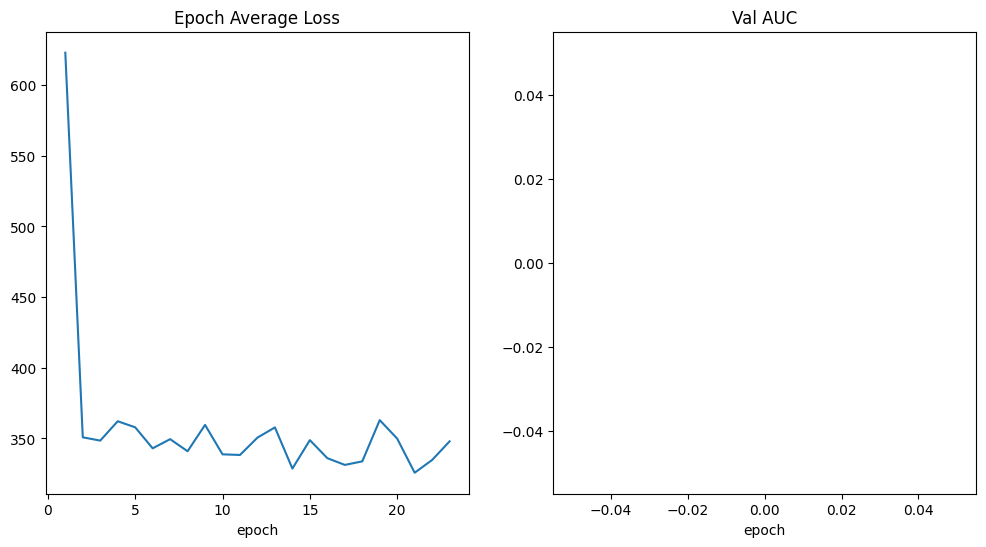

In [26]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

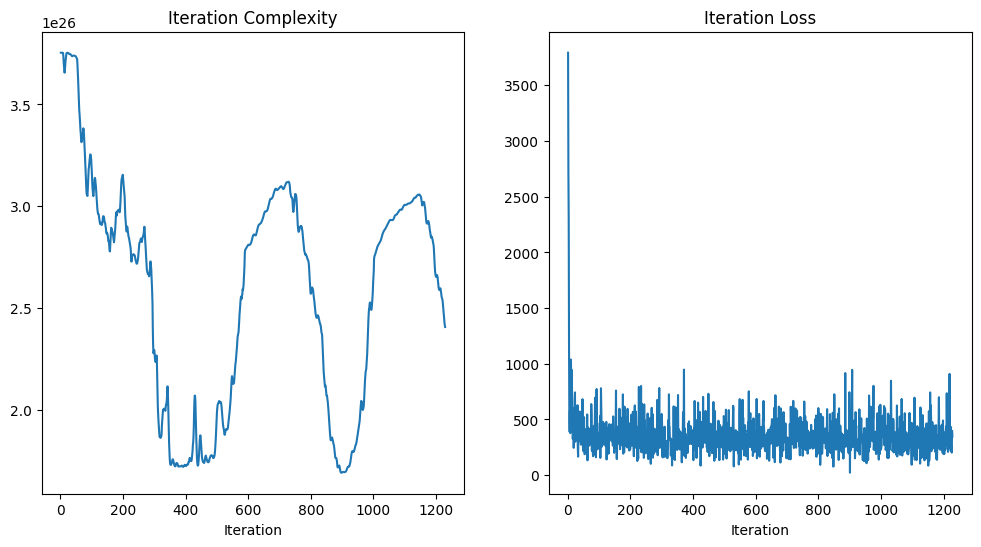

In [27]:
fig = plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Complexity")
x = [i + 1 for i in range(len(single_complexity))]
y = single_complexity
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Iteration Loss")
x = [val_interval * (i + 1) for i in range(len(single_loss))]
y = single_loss
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()
fig.savefig('complexity.png')


In [29]:

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [32]:
y_true

[72.0,
 52.0,
 66.0,
 79.0,
 74.0,
 33.0,
 53.0,
 38.0,
 22.0,
 80.0,
 44.0,
 84.0,
 5.0,
 45.0,
 79.0,
 28.0,
 77.0,
 82.0,
 47.0,
 67.0,
 73.0,
 78.0,
 58.0,
 60.0,
 71.0,
 73.0,
 45.0,
 64.0,
 76.0,
 52.0,
 87.0,
 50.0,
 80.0,
 66.0,
 41.0,
 82.0,
 67.0,
 34.0,
 85.0,
 69.0,
 78.0,
 71.0,
 77.0,
 53.0,
 69.0,
 79.0,
 58.0,
 68.0,
 26.0,
 70.0,
 75.0,
 67.0,
 83.0,
 60.0,
 73.0,
 78.0,
 84.0,
 47.0,
 42.0,
 73.0,
 65.0,
 77.0,
 62.0,
 74.0,
 76.0,
 55.0,
 69.0,
 82.0,
 36.0,
 58.0,
 78.0,
 55.0,
 80.0,
 80.0,
 84.0,
 79.0,
 53.0,
 28.0,
 80.0,
 50.0,
 77.0,
 31.0,
 15.0,
 56.0,
 42.0,
 67.0,
 87.0,
 53.0,
 49.0,
 73.0,
 46.0,
 54.0,
 60.0,
 73.0,
 47.0,
 51.0,
 51.0,
 74.0,
 40.0,
 47.0,
 20.0,
 80.0,
 78.0,
 28.0,
 30.0]

: 